In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import shap
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization

In [16]:
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']
returns = data.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [17]:
data.head()

Ticker,HDFCBANK.NS,ICICIBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,,,
2020-01-01,1227.428589,518.854065,661.205261,673.421997,2010.579102
2020-01-02,1235.252441,522.575623,659.276001,684.886597,2001.350098
2020-01-03,1217.636841,520.884033,669.415833,685.711853,2041.234619
2020-01-06,1191.285522,508.172455,662.999817,669.808655,2041.049194
2020-01-07,1210.148926,505.465820,653.174011,680.113342,2046.058105


In [18]:
def portfolio_performance(weights, returns):
    weights = np.array(weights)
    port_return = np.sum(returns.mean() * weights) * 252  # Annualized return
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized risk
    sharpe_ratio = port_return / port_volatility  # Risk-adjusted return
    return sharpe_ratio

In [19]:
def optimize_portfolio():
    def objective(**weights):
        weight_array = np.array(list(weights.values()))
        return portfolio_performance(weight_array, returns)
    
    pbounds = {f'w{i}': (0, 1) for i in range(len(tickers))}
    optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=50)
    
    best_weights = np.array([optimizer.max['params'][f'w{i}'] for i in range(len(tickers))])
    best_weights /= best_weights.sum()  # Ensure weights sum to 1
    return best_weights

In [20]:
# Custom user-defined weights before optimization
old_weights = np.array([0.3, 0.2, 0.2, 0.15, 0.15])

# Calculate portfolio return before optimization
old_return = portfolio_performance(old_weights, returns)

# Get optimized portfolio weights
new_weights = optimize_portfolio()

# Calculate portfolio return after optimization
new_return = portfolio_performance(new_weights, returns)

|   iter    |  target   |    w0     |    w1     |    w2     |    w3     |    w4     |
-------------------------------------------------------------------------------------
| 1         | 0.8952    | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     |
| 2         | 0.9489    | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    |
| 3         | 0.9255    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    |
| 4         | 0.9463    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    |
| 5         | 0.8457    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    |
| 6         | 0.8823    | 0.3871    | 0.6911    | 0.258     | 0.832     | 0.6098    |
| 7         | 0.8145    | 0.9064    | 0.1054    | 0.1473    | 0.9253    | 0.7707    |
| 8         | 0.6798    | 0.584     | 0.04778   | 0.03581   | 0.1045    | 0.2332    |
| 9         | 0.9764    | 0.0       | 0.4844    | 0.8947    | 0.4141    | 0.525     |
| 10        | 0.9609    | 0.008482  | 0.3282    | 0.90

In [21]:
print("\n--- Portfolio Optimization Results ---")
print("Custom Portfolio Weights (Before Optimization):", old_weights)
print("Optimized Portfolio Weights (After Optimization):", new_weights)
print(f"Expected Return Before Optimization: {old_return:.4f}")
print(f"Expected Return After Optimization: {new_return:.4f}")


--- Portfolio Optimization Results ---
Custom Portfolio Weights (Before Optimization): [0.3  0.2  0.2  0.15 0.15]
Optimized Portfolio Weights (After Optimization): [0.00684054 0.15732507 0.47510877 0.2458176  0.11490802]
Expected Return Before Optimization: 0.8498
Expected Return After Optimization: 0.9792


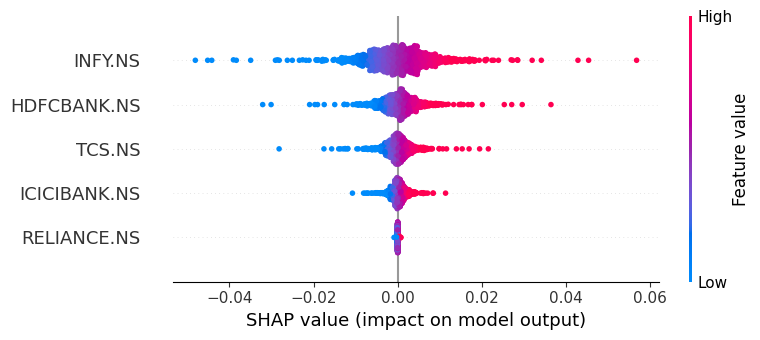

In [10]:
# Explainable AI (XAI) using SHAP
explainer = shap.Explainer(lambda x: np.dot(x, new_weights), returns.values)
shap_values = explainer(returns.values)

# Generate SHAP summary plot for all stocks together
shap.summary_plot(shap_values, returns, feature_names=tickers)


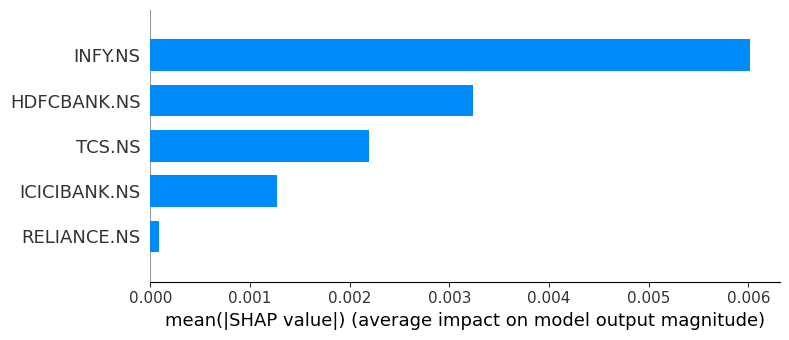

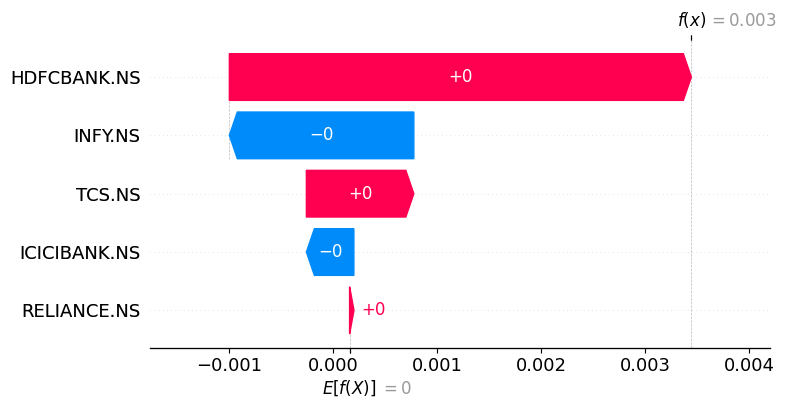

In [23]:
import shap

# Explainable AI (XAI) using SHAP
explainer = shap.Explainer(lambda x: np.dot(x, new_weights), returns.values)
shap_values = explainer(returns.values)

# SHAP Bar Plot - Shows feature importance
shap.summary_plot(shap_values, returns, feature_names=tickers, plot_type="bar")

# SHAP Waterfall Plot - Explains SHAP values for a specific sample (e.g., first portfolio state)
shap.waterfall_plot(shap.Explanation(values=shap_values[0].values, 
                                     base_values=shap_values[0].base_values, 
                                     feature_names=tickers))



In [12]:
# Explain optimization results in a simple way
print("\n--- SHAP-Based Explanations for Portfolio Optimization ---")
for i, stock in enumerate(tickers):
    impact = np.mean(shap_values[:, i].values)
    if impact > 0:
        explanation = f"{stock} had a positive impact on the optimized portfolio, so its weight was increased."
    else:
        explanation = f"{stock} had a negative or neutral impact, leading to a decrease or no change in its weight."
    print(explanation)


--- SHAP-Based Explanations for Portfolio Optimization ---
RELIANCE.NS had a positive impact on the optimized portfolio, so its weight was increased.
TCS.NS had a positive impact on the optimized portfolio, so its weight was increased.
INFY.NS had a positive impact on the optimized portfolio, so its weight was increased.
HDFCBANK.NS had a positive impact on the optimized portfolio, so its weight was increased.
ICICIBANK.NS had a positive impact on the optimized portfolio, so its weight was increased.
